In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook



#import cv2
import pims
from PIL import Image

import skimage

import json

import sys
sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

# cube as a mesh

In [2]:
def getCubeMeshIndexes(cubeSize = 5, center=[0,0,0]):
# this is 5 on each side of the center
#center=np.array([224.29615185,362.37867407,45.60376889])
    indexes = []
    limits = np.array([-cubeSize,+cubeSize])
    for i in range(limits[0]-2,limits[1]+2):
        for j in  range(limits[0]-2,limits[1]+2):
            for k in range(limits[0]-2,limits[1]+2):
                value = 0
                if i in (limits+center[0]) and j in (limits+center[1]) and ((k > (limits+center[2])[0]) and (k < (limits+center[2])[1])) :
    #                print(limits+centerOfImage[0]+coord[0])
    #                print(limits+centerOfImage[1]+coord[1])
                    indexes.append([i,j,k])
                if j in limits+center[1] and k in limits+center[2] and ((i > (limits+center[0])[0]) and (i < (limits+center[0])[1])) :
                    indexes.append([i,j,k])
                if k in limits+center[2] and i in limits+center[0] and ((j > (limits+center[1])[0]) and (j < (limits+center[1])[1])) :
                    indexes.append([i,j,k])
    return(indexes)

# helper functions for lattice image processing

In [3]:
def maxIntensityProjection(latticeMovieFrame):
    
    path = inputDataFolder+'/'+ch0_filesOfInterest[0]
    latticeMovieFrame = skimage.external.tifffile.imread(inputDataFolder+'/'+ch0_filesOfInterest[10])
    
    f, axarr = plt.subplots(1,3,dpi=300)
    
    axarr[0].imshow(np.max(latticeMovieFrame,axis=0))
    axarr[0].set_xlabel('x')
    axarr[0].set_ylabel('y')
    axarr[0].invert_yaxis()
    
    
    axarr[1].imshow(np.max(latticeMovieFrame,axis=1))
    axarr[1].set_xlabel('x')
    axarr[1].set_ylabel('z')
    axarr[1].invert_yaxis()
    
    
    
    axarr[2].imshow(np.max(latticeMovieFrame,axis=2))
    axarr[2].set_xlabel('y')
    axarr[2].set_ylabel('z')
    axarr[2].invert_yaxis()
    
    plt.tight_layout()
    
    plt.show()

In [4]:
from os import listdir
from os.path import isfile, join
import fnmatch

def getFilenamesOfInputTiffFiles(inputDataFolder,uniqueFilenameString):

    folder = inputDataFolder
    print('--- folder searched in: '+folder)
    
    filesOfInterest = []
    for file in listdir(inputDataFolder):
        if isfile(join(inputDataFolder, file)) and fnmatch.fnmatch(file, '*'+uniqueFilenameString+'*.tif'):
            filesOfInterest.append(file)
    filesOfInterest=np.sort(filesOfInterest)
    
    
    
    print('--- example of files found: '+filesOfInterest[0])
    print('--- number of files found: '+str(len(filesOfInterest)))
    
    return(filesOfInterest)



# helper functions for this

In [5]:
def getRidOfNegativeIndexes(indexesArray):
    newIndexes = []
    for index in indexesArray:
        if(np.min(index)>=0):
            newIndexes.append(index)
    return(np.array(newIndexes))

In [6]:
def getIndexesWhereAllArrayEntriesArePositive(indexesArray):
    newIndexes = []
    for i in range(0,len(indexesArray)):
        index=indexesArray[i]
        if(np.min(index)>=0):
            newIndexes.append(i)
    return(np.array(newIndexes))

# input

In [7]:
def getInputParameter(inputParametersPandas,key):
    #this locates the row, gets the result out of its array form and strips whitespaces away
    return (((inputParametersPandas.loc[inputParametersPandas['key'] == key]).values)[0,1]).strip()

In [8]:
inputParameters = pd.read_csv('../../input/_inputParameters.csv',names=['key','value'])
inputParameters.style.set_properties(**{'text-align': 'left'})
#inputParameters

,key,value
0,inputDataFolder,/Users/johannesschoeneberg/Desktop/PostDoc/drubin_lab/organoids_lattice_data/data_/2016_04_25Daphne/Sample3_CD_10ulMG/Position5_Basal_apical_ObjScan/matlab_decon
1,outputDataFolder,/Users/johannesschoeneberg/git/pyLattice/input/big_data_cutoff7000/output
2,movieLength,70
3,allowedMaxNumDetectionsPerFrame,3000 -- deprecated
4,detectionAmplitudeCutoff,7000
5,framerate_msec,5689
6,detectionFilename,Detection3D.mat
7,trackingFilename,trackedFeatures.mat
8,trackingCsvFilename,trackedFeatures.csv
9,trackingFilenameProcessed,trackedFeaturesProcessed.mat


In [9]:
inputDataFolder = getInputParameter(inputParameters,"inputDataFolder")
inputDataFolder = '/Volumes/6big/Daphne_Janelia_1/2016_04_28_Daphne/Sample7_CD_LY_10ulMG/Position2_O1/matlab_decon'
outputDataFolder = getInputParameter(inputParameters,"outputDataFolder")
slave_outputDataFolder  = getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = getInputParameter(inputParameters,"master_outputDataFolder")
trackingCsvFilename = getInputParameter(inputParameters,"trackingCsvFilename")

slave_uniqueFilenameString = getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = getInputParameter(inputParameters,"master_uniqueFilenameString")
#trackColor = getInputParameter(inputParameters,"trackColor")
#trackingBildFilename = getInputParameter(inputParameters,"trackingBildFilename")
#framerate_msec = float(getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(getInputParameter(inputParameters,"movieLength"))
#print(trackColor)

In [10]:
    slave_filesOfInterest = getFilenamesOfInputTiffFiles(inputDataFolder,slave_uniqueFilenameString)
    master_filesOfInterest = getFilenamesOfInputTiffFiles(inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Volumes/6big/Daphne_Janelia_1/2016_04_28_Daphne/Sample7_CD_LY_10ulMG/Position2_O1/matlab_decon
--- example of files found: S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0000_488nm_0000000msec_0028982467msecAbs_000x_000y_003z_0000t_decon.tif
--- number of files found: 120
--- folder searched in: /Volumes/6big/Daphne_Janelia_1/2016_04_28_Daphne/Sample7_CD_LY_10ulMG/Position2_O1/matlab_decon
--- example of files found: S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0000_560nm_0000000msec_0028982467msecAbs_000x_000y_003z_0000t_decon.tif
--- number of files found: 120


# Master

In [11]:
frameId = 0

/Volumes/6big/Daphne_Janelia_1/2016_04_28_Daphne/Sample7_CD_LY_10ulMG/Position2_O1/matlab_decon/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0069_560nm_0241501msec_0029223968msecAbs_000x_000y_003z_0000t_decon.tif
(126, 704, 512)


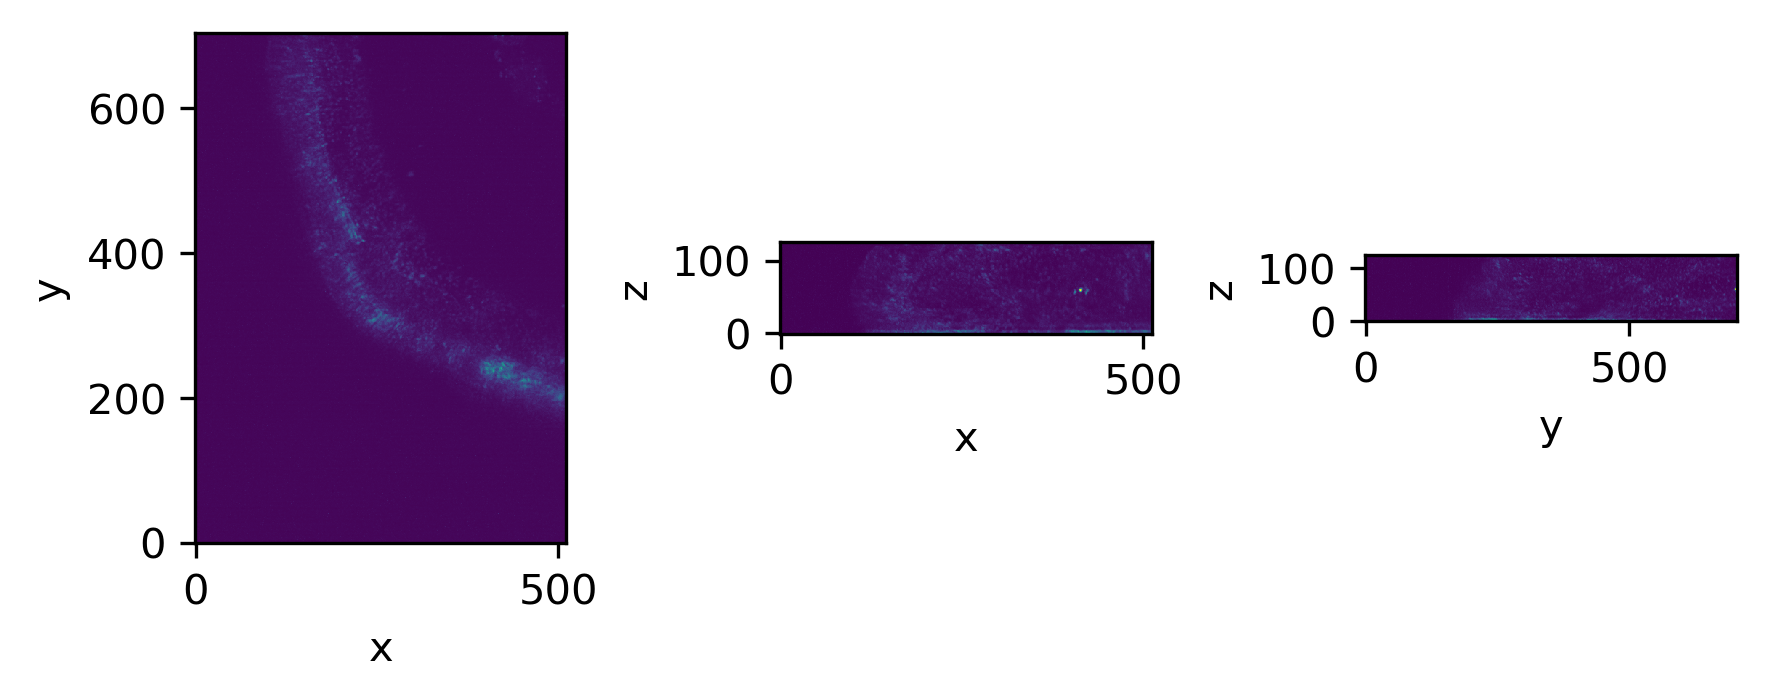

In [12]:
# read the image from where the detections come from
frameId = 69

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

/Volumes/6big/Daphne_Janelia_1/2016_04_28_Daphne/Sample7_CD_LY_10ulMG/Position2_O1/matlab_decon/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0000_560nm_0000000msec_0028982467msecAbs_000x_000y_003z_0000t_decon.tif


Text(0.5,1,'frameID 0')

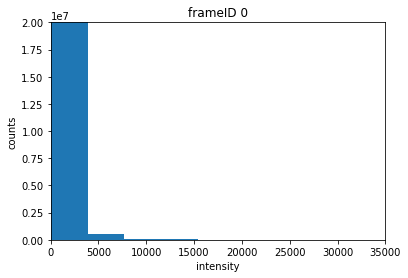

In [13]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)

plt.hist(latticeMovieFrame.flatten(),bins=100);
plt.ylim(0,20000000) 
plt.xlim(0,35000)
plt.xlabel('intensity')
plt.ylabel('counts')
plt.title('frameID '+str(frameId))

In [14]:
# read the image from where the detections come from

m_frame_max = []
m_frame_mean = []
m_ratio = []
s_frame_max = []
s_frame_mean = []
s_ratio = []
for frameId in range(0,70):

    path = inputDataFolder+'/'+master_filesOfInterest[frameId]
    #print(path)
    latticeMovieFrame = skimage.external.tifffile.imread(path)
    
    m_frame_max.append(np.max(latticeMovieFrame))
    m_frame_mean.append(np.mean(latticeMovieFrame))
    m_ratio.append(np.mean(latticeMovieFrame)/np.mean(skimage.external.tifffile.imread(inputDataFolder+'/'+master_filesOfInterest[0])))
    
    path = inputDataFolder+'/'+slave_filesOfInterest[frameId]
    #print(path)
    latticeMovieFrame = skimage.external.tifffile.imread(path)
    
    s_frame_max.append(np.max(latticeMovieFrame))
    s_frame_mean.append(np.mean(latticeMovieFrame))
    s_ratio.append(np.mean(latticeMovieFrame)/np.mean(skimage.external.tifffile.imread(inputDataFolder+'/'+slave_filesOfInterest[0])))



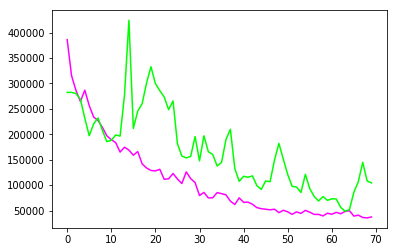

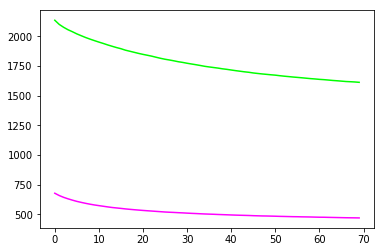

Text(0,0.5,'ratio')

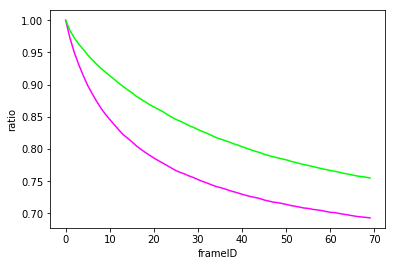

In [15]:
plt.plot(m_frame_max,c='magenta')
plt.plot(s_frame_max,c='lime')
plt.show()
plt.plot(m_frame_mean,c='magenta')
plt.plot(s_frame_mean,c='lime')
plt.show()
#fig = plt.figure(dpi=300)
plt.plot(m_ratio,c='magenta')
plt.plot(s_ratio,c='lime')
plt.xlabel('frameID')
plt.ylabel('ratio')

In [16]:
# ratio method

In [17]:
# read the image from where the detections come from

for frameId in range(0,movieLength):

    
    # master files
    path = inputDataFolder+'/'+master_filesOfInterest[frameId]
    #print(path)
    latticeMovieFrame = skimage.external.tifffile.imread(path)
    

    data = latticeMovieFrame/m_ratio[frameId]
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    metadata = json.dumps(metadata)
    
    output_filename = master_filesOfInterest[frameId]+'_ratioCorrected.tif'
    
    outputDataFolder = '/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr'
    path = outputDataFolder+'/'+output_filename

    print(path)
    
    skimage.external.tifffile.imsave(path, data, description=metadata)
    
    
    
    # slave files
    path = inputDataFolder+'/'+slave_filesOfInterest[frameId]
    #print(path)
    latticeMovieFrame = skimage.external.tifffile.imread(path)
    

    data = latticeMovieFrame/s_ratio[frameId]
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    metadata = json.dumps(metadata)
    
    output_filename = slave_filesOfInterest[frameId]+'_ratioCorrected.tif'
    path = outputDataFolder+'/'+output_filename
    print(path)
    
    skimage.external.tifffile.imsave(path, data, description=metadata)

/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0000_560nm_0000000msec_0028982467msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0000_488nm_0000000msec_0028982467msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0001_560nm_0003500msec_0028985967msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0001_488nm_0003500msec_0028985967msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrec

/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0016_488nm_0056000msec_0029038467msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0017_560nm_0059500msec_0029041967msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0017_488nm_0059500msec_0029041967msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0018_560nm_0063000msec_0029045467msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrec

/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0033_560nm_0115500msec_0029097967msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0033_488nm_0115500msec_0029097967msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0034_560nm_0119000msec_0029101467msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0034_488nm_0119000msec_0029101467msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrec

/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0049_488nm_0171501msec_0029153968msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0050_560nm_0175001msec_0029157468msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0050_488nm_0175001msec_0029157468msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0051_560nm_0178501msec_0029160968msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrec

/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0066_560nm_0231001msec_0029213468msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0066_488nm_0231001msec_0029213468msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0067_560nm_0234501msec_0029216968msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/S7P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0067_488nm_0234501msec_0029216968msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrec

In [35]:
# model based method (exponential decay)

nonlinear 898.480943894 -0.0482470599473 1625.87499794
898.480943894 -0.0482470599473 1625.87499794
linear -0.02871835899 6.78260486495


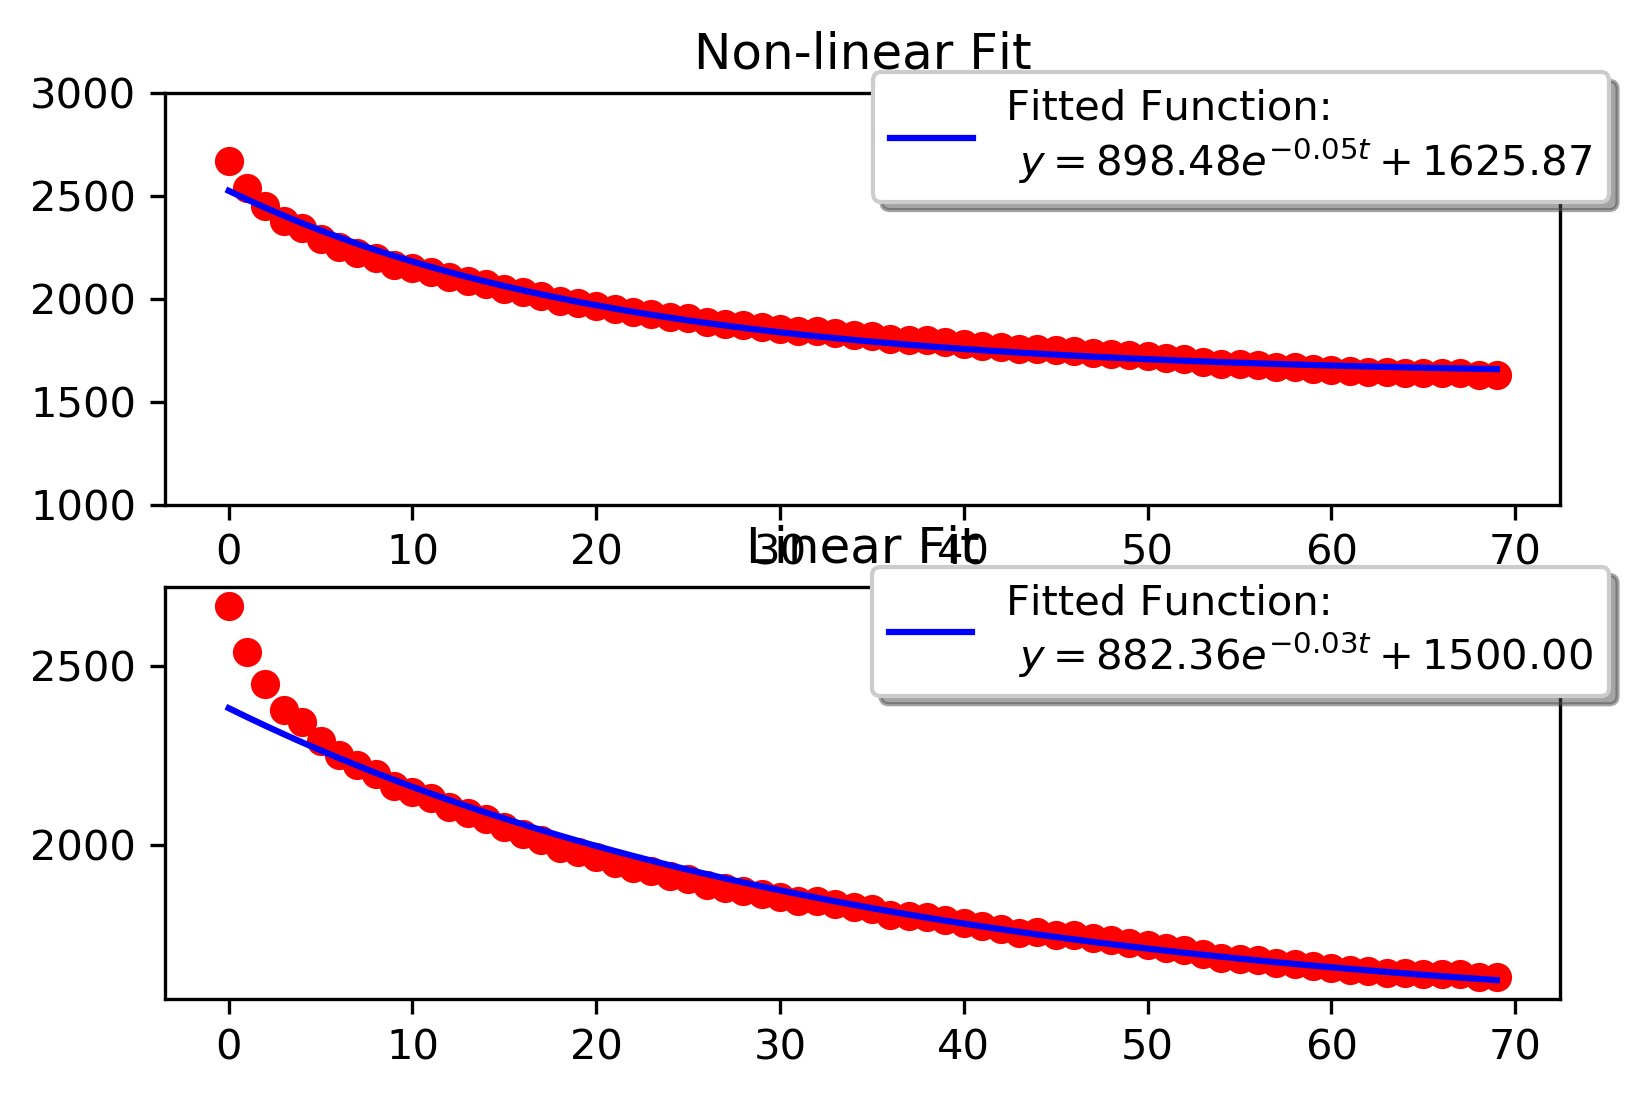

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize


def main():

    t = np.array(range(0,70))
    y = np.array(frame_mean)
    C0= 1500


    fig = plt.figure(dpi=300)
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # Non-linear Fit
    A, K, C = fit_exp_nonlinear(t, y)
    print(A,K,C)
    fit_y = model_func(t, A, K, C)
    plot(ax1, t, y, fit_y, (A, K, C))
    ax1.set_title('Non-linear Fit')
    ax1.set_ylim(1000,3000)

    # Linear Fit (Note that we have to provide the y-offset ("C") value!!
    A, K = fit_exp_linear(t, y, C0)
    fit_y = model_func(t, A, K, C0)
    plot(ax2, t, y, fit_y, (A, K, C0))
    ax2.set_title('Linear Fit')

    plt.show()

def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    print('linear',K,A_log)
    return A, K

def fit_exp_nonlinear(t, y):
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, t, y, maxfev=10000,p0=(0 ,-0.3, 1500))
    A, K, C = opt_parms
    print('nonlinear',A,K,C)
    return A, K, C

def plot(ax, t, y, fit_y, fit_parms):
    A, K, C = fit_parms
    
    ax.plot(t, y, 'ro')
    ax.plot(t, fit_y, 'b-',
      label='Fitted Function:\n $y = %0.2f e^{%0.2f t} + %0.2f$' % (A, K, C))

    ax.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)

if __name__ == '__main__':
    main()

In [15]:
# read the detected coordinates
detectedPunctaPerFrameArray = []
for frameId in range(0,movieLength):

    # matlab format rule: fmt = ['%.' num2str(ceil(log10(movieLength+1))) 'd'];
    numberOfZeros = int(np.ceil(np.log10(movieLength+1)))
    input_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.csv'
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    
    path = outputDataFolder+'/'+master_outputDataFolder+'/'+input_filename
    print(path)
    
    data = pd.read_csv(path,header=0)
    data.columns = ["x","y","z","A"]
    
    
    #### WARNING ####
    
    # this is really weird!
    # for some reason, I have to invert all the coordinates to display them again...
    
    allDetectedPunctaInFrame = data[['z','y','x']].values.astype(int)-np.array([1,1,1])
    print('#puncta read in frameId '+str(frameId)+':',len(allDetectedPunctaInFrame))
    detectedPunctaPerFrameArray.append(allDetectedPunctaInFrame)

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_01.csv
#puncta read in frameId 0: 140
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_02.csv
#puncta read in frameId 1: 151
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_03.csv
#puncta read in frameId 2: 144
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_04.csv
#puncta read in frameId 3: 152
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_05.csv
#puncta read in frameId 4: 153
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_06.csv
#puncta read in frameId 5: 161
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_07.csv
#puncta read in frameId 6: 168
/Users/johannesschoe

# write the cubes

In [17]:
# this works. Nice!


margin = 0

imageSizeOriginal = latticeMovieFrame_shape
imageSize = np.array((imageSizeOriginal[0]+margin,imageSizeOriginal[1]+margin,imageSizeOriginal[2]+margin))


centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])
centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])

for frameId in range(0,movieLength):

    boxCenters = detectedPunctaPerFrameArray[frameId]
    
    image = np.zeros(imageSize)
    print(imageSize)
    
    meshIndexes = getCubeMeshIndexes()
    meshIndexesAdjustedArray = []
    counter = 0
    
    for boxCenter in boxCenters:
        
        
        if counter%100 == 0:
            print(counter)
            
            
     #   if(boxCenter[1]>imageSize[1]):
     #       boxCenter[1]=boxCenter[1]-imageSize[1]
     #       print(boxCenter)
    
    
        # I run into problems if the box Center leads to negative values -> prune them
        meshIndexesAdjusted = meshIndexes+boxCenter
        if np.min(meshIndexesAdjusted)<0:
            meshIndexesAdjusted = meshIndexesAdjusted[getIndexesWhereAllArrayEntriesArePositive(meshIndexesAdjusted)]
        meshIndexesAdjustedArray.append(meshIndexesAdjusted)
        
        
        # I run into problems if the box center leads to indexes that are larger than the image -> prune them
        boolArray = boxCenter+np.array([6,6,6]) >= imageSize
        if(True in boolArray):
            # these values are larger than the image size, subtract the image size first, get negative values
            tmp = imageSize-np.array([1,1,1]) - meshIndexesAdjusted
            # add the image size back after gotten rid of the negative ones
            idx=getIndexesWhereAllArrayEntriesArePositive(tmp)
            if(len(idx)==0):
                print('weird box center (not in image), excluded from display: ')
                print(boxCenter)
                print(imageSize)
                meshIndexesAdjusted = []
            else:
                meshIndexesAdjusted = meshIndexesAdjusted[idx]
                    
            
        
        
        for index in meshIndexesAdjusted:
            #print(index)
        #    print('index',index)
            image[index[0],index[1],index[2]]=10
        
        #print(image)
        
        
        counter = counter+1

    data = image.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    metadata = json.dumps(metadata)
    print(metadata)
    
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    path = outputDataFolder+'/'+master_outputDataFolder+'/'+output_filename
    print(path)
    
    skimage.external.tifffile.imsave(path, data, description=metadata)
    

[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_01.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_02.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_03.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_04.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_560/puncta_05.tiff
[100 100 100]
0
100
{"microsco

# Slave

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100//cropped_488_pm50px_maxAmpl_0000.tif
(100, 100, 100)


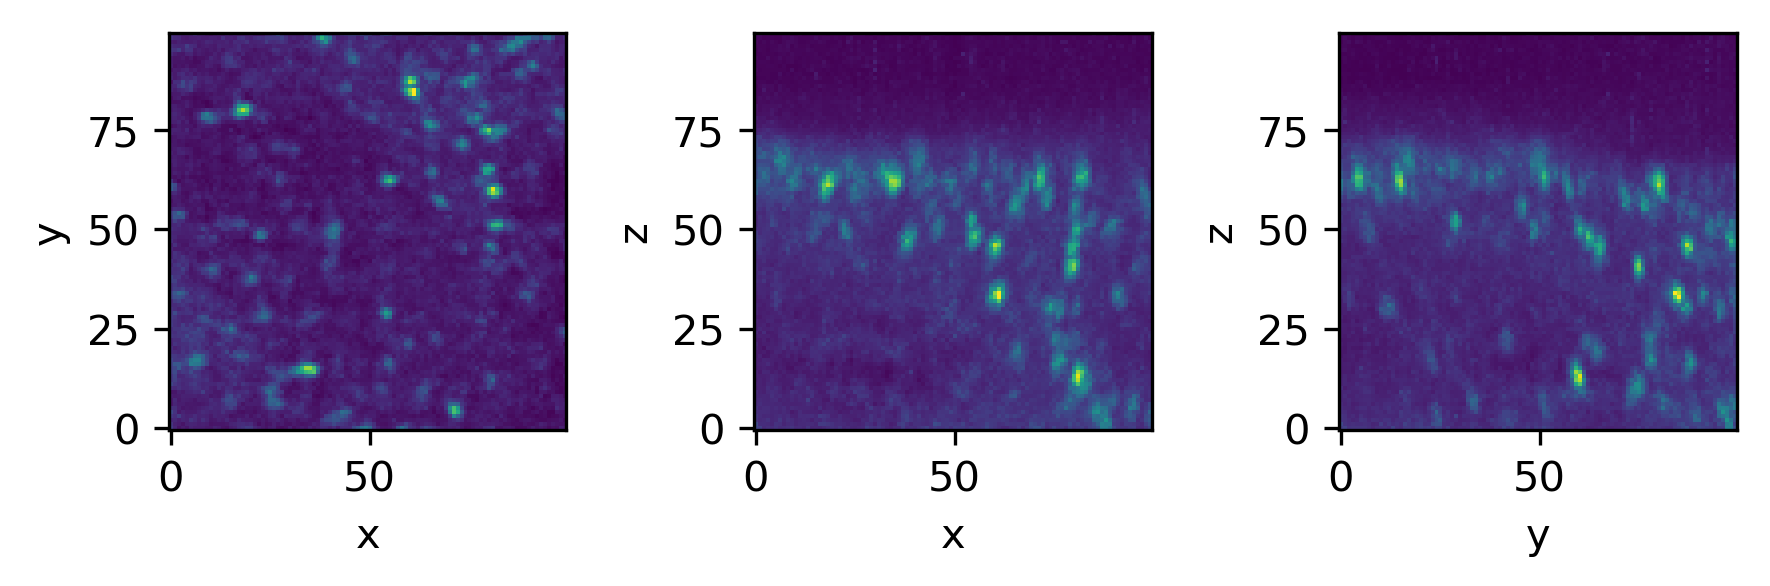

In [18]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+slave_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

In [19]:
# read the detected coordinates
detectedPunctaPerFrameArray = []
for frameId in range(0,movieLength):

    # matlab format rule: fmt = ['%.' num2str(ceil(log10(movieLength+1))) 'd'];
    numberOfZeros = int(np.ceil(np.log10(movieLength+1)))
    input_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.csv'
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    
    path = outputDataFolder+'/'+slave_outputDataFolder+'/'+input_filename
    print(path)
    
    data = pd.read_csv(path,header=0)
    data.columns = ["x","y","z","A"]
    
    
    #### WARNING ####
    
    # this is really weird!
    # for some reason, I have to invert all the coordinates to display them again...
    
    allDetectedPunctaInFrame = data[['z','y','x']].values.astype(int)-np.array([1,1,1])
    print('#puncta read in frameId '+str(frameId)+':',len(allDetectedPunctaInFrame))
    detectedPunctaPerFrameArray.append(allDetectedPunctaInFrame)

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_01.csv
#puncta read in frameId 0: 140
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_02.csv
#puncta read in frameId 1: 151
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_03.csv
#puncta read in frameId 2: 144
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_04.csv
#puncta read in frameId 3: 152
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_05.csv
#puncta read in frameId 4: 153
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_06.csv
#puncta read in frameId 5: 161
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_07.csv
#puncta read in frameId 6: 168
/Users/johannesschoe

In [20]:
# this works. Nice!


margin = 0

imageSizeOriginal = latticeMovieFrame_shape
imageSize = np.array((imageSizeOriginal[0]+margin,imageSizeOriginal[1]+margin,imageSizeOriginal[2]+margin))


centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])
centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])

for frameId in range(0,movieLength):

    boxCenters = detectedPunctaPerFrameArray[frameId]
    
    image = np.zeros(imageSize)
    print(imageSize)
    
    meshIndexes = getCubeMeshIndexes()
    meshIndexesAdjustedArray = []
    counter = 0
    
    for boxCenter in boxCenters:
        
        
        if counter%100 == 0:
            print(counter)
            
            
     #   if(boxCenter[1]>imageSize[1]):
     #       boxCenter[1]=boxCenter[1]-imageSize[1]
     #       print(boxCenter)
    
    
        # I run into problems if the box Center leads to negative values -> prune them
        meshIndexesAdjusted = meshIndexes+boxCenter
        if np.min(meshIndexesAdjusted)<0:
            meshIndexesAdjusted = meshIndexesAdjusted[getIndexesWhereAllArrayEntriesArePositive(meshIndexesAdjusted)]
        meshIndexesAdjustedArray.append(meshIndexesAdjusted)
        
        
        # I run into problems if the box center leads to indexes that are larger than the image -> prune them
        boolArray = boxCenter+np.array([6,6,6]) >= imageSize
        if(True in boolArray):
            # these values are larger than the image size, subtract the image size first, get negative values
            tmp = imageSize-np.array([1,1,1]) - meshIndexesAdjusted
            # add the image size back after gotten rid of the negative ones
            idx=getIndexesWhereAllArrayEntriesArePositive(tmp)
            if(len(idx)==0):
                print('weird box center (not in image), excluded from display: ')
                print(boxCenter)
                print(imageSize)
                meshIndexesAdjusted = []
            else:
                meshIndexesAdjusted = meshIndexesAdjusted[idx]
                    
            
        
        
        for index in meshIndexesAdjusted:
            #print(index)
        #    print('index',index)
            image[index[0],index[1],index[2]]=10
        
        #print(image)
        
        
        counter = counter+1

    data = image.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    metadata = json.dumps(metadata)
    print(metadata)
    
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    path = outputDataFolder+'/'+slave_outputDataFolder+'/'+output_filename
    print(path)
    
    skimage.external.tifffile.imsave(path, data, description=metadata)
    

[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_01.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_02.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_03.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_04.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_05.tiff
[100 100 100]
0
100
{"microsco